In [37]:
import sys
# Delete all global variables when re-running the notebook.
this = sys.modules[__name__] # type: ignore
for n in dir():
    if n in ['this', 'was_mounted']: continue
    if n[0]!='_': delattr(this, n)


try:
    was_mounted = was_mounted
except:
    was_mounted = False


import os
if  os.getenv("COLAB_RELEASE_TAG"):
  is_running_on_colab = True

else:
  is_running_on_colab = False

if is_running_on_colab:
  packages_to_install = ['pandas==2.1.3','neurokit2', 'wfdb']

  for package in packages_to_install:
    os.system(f'pip install {package}')
  from google.colab import drive, files
  code_directory = './gdrive/MyDrive/TCC/ectopic_beats_detection'
  if not was_mounted:
      drive.mount('/content/gdrive')
  was_mounted = True
  if not os.path.samefile(os.getcwd(),code_directory):
    os.chdir(code_directory)

from utils import create_compare_df, create_dict_results, plot_results, calculate_metrics, resolve_relative_path
from globals import *
import sys
import neurokit2 as nk
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pyarrow as pa
from os.path import join
import pyarrow as pa
from typing import Any, Dict, Iterable, List, Tuple, Union
from numpy import typing as npt
from utils import  load_df_multi_analysis, load_record, show_image
from datetime import datetime
import pickle
from multiprocessing import Pool, cpu_count
from timeit import default_timer as timer
import glob
from numba import njit
import cv2
import numpy as np
import gc

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)



@njit(cache = True, nogil=True)
def sig_2_pic(signal,height, width,scale):
    samples = signal.shape[0]
    scale_image = (height-10)
    offset = 5
    new_image = np.ones((height, width), dtype=np.uint8)


    x_array = np.arange(0, samples, 1,dtype=np.int32)*(width)//(samples)
    y_array = (scale*scale_image*((signal - signal.min()) / (signal.max() - signal.min()))).astype(np.int32) + offset

    for idx in range(x_array.shape[0] - 1):
        x0, y0, x1, y1 =x_array[idx], y_array[idx], x_array[idx+1], y_array[idx+1]

        ############### Bresenham algorithm ###############
        dx = x1 - x0
        dy = y1 - y0

        xsign = 1 if dx > 0 else -1
        ysign = 1 if dy > 0 else -1

        dx = abs(dx)
        dy = abs(dy)

        if dx > dy:
            xx, xy, yx, yy = xsign, 0, 0, ysign
        else:
            dx, dy = dy, dx
            xx, xy, yx, yy = 0, ysign, xsign, 0

        D = 2*dy - dx
        y = 0

        for x in range(dx + 1):
            xc, yc =  x0 + x*xx + y*yx, y0 + x*xy + y*yy
            new_image[height-1 - yc,xc] = 0
            if D >= 0:
                y += 1
                D -= 2*dx
            D += 2*dy
        ###################################################
        
    return new_image





old_vars = dir()

df_record_lead_ann = pd.read_parquet(join(dataframes_directory, 'df_record_lead_ann.parquet'))
df_lead_ann_summery =  pd.read_parquet(join(dataframes_directory, 'df_lead_ann_summery.parquet'))
df_ann_summery = pd.read_parquet(join(dataframes_directory, 'df_ann_summery.parquet'))
df_code_description = pd.read_parquet(join(dataframes_directory, 'df_code_description.parquet'))

df_multi_analysis = load_df_multi_analysis(glob.glob(join(dataframes_directory, 'dict_multi_analysis*.pickle')))

In [38]:
list_record_track =  []

for idx, row in df_record_lead_ann.iterrows():
    if row['upper_signal'] == 'MLII':
        signal_track = 0
    elif row['lower_signal'] == 'MLII':
        signal_track = 1
    else:
        continue
    list_record_track.append({'record': row['record'], 'track': signal_track})


In [39]:
derised_anns = LIST_BEATS_2
discard_time = 100
df = pd.DataFrame({'record': pd.Series(dtype=np.uint8),
                   'ecg_beat_indexes': pd.Series(dtype=INDEX_TYPE),
                   'ecg_beat_indexes': pd.Series(dtype=ANN_TYPE)})

dict_records_info = {}
for item in list_record_track:
    record_num = item['record']
    track_num = item['track']

    record, ann = load_record(record_num)

    ecg = record.p_signal[:, 0] #+ record.p_signal[:, 1] # type: ignore
 
    ecg_beat_indexes = pd.Series(ann.sample, dtype=INDEX_TYPE)
    ecg_beat_anns = pd.Series(ann.symbol, dtype=ANN_TYPE)

     # Mask for time window and derised annotations
    mask_derised_ann = ecg_beat_anns.isin(derised_anns)

    ecg_beat_indexes = ecg_beat_indexes[mask_derised_ann].reset_index(drop=True)
    ecg_beat_anns = ecg_beat_anns[mask_derised_ann].reset_index(drop=True)

    aux_df = pd.DataFrame(
    {
        'record': record_num * np.ones(ecg_beat_indexes.shape[0]-2, dtype=np.uint8),
        'ecg_beat_indexes': ecg_beat_indexes.iloc[1:-1],
        'ecg_beat_anns': ecg_beat_anns.iloc[1:-1]
    }
    )

    df = pd.concat([df, aux_df], ignore_index=True, axis=0)

    dict_records_info[record_num] = {
    'ecg': ecg,
    'ecg_beat_indexes': ecg_beat_indexes,
    'ecg_beat_anns': ecg_beat_anns
    }

dict_df_beat_type = {}
for beat_type in derised_anns:
    # Shuffle the dataframe and save it in a dictionary
    dict_df_beat_type[beat_type] = {
        'df':df[df['ecg_beat_anns'] == beat_type].sample(frac=1).reset_index(drop=True), 
        'idx': 0
        }


beat_type_quants = df.ecg_beat_anns.value_counts()


for v in dir():
    if v not in old_vars + ['dict_df_beat_type', 'list_record_track', 'dict_records_info', 'old_vars', 'derised_anns']:
        #print(v)
        delattr(this, v)
gc.collect()

820910

In [41]:
dict_quant_per_batch = {
    'N': 10,
    'L': 5,
    'R': 4,
    'V': 4,
    '/': 4,
    'A': 2,
    '!': 2,
    'E': 1,
 }

dict_beat_to_int = {
    'N': 0,
    'L': 1,
    'R': 2,
    'V': 3,
    '/': 4,
    'A': 5,
    '!': 6,
    'E': 7,
}

dict_beat_acronyms = {
    'N': 'NOR',
    'L': 'LBB',
    'R': 'RBB',
    'V': 'PVC',
    '/' : 'PAB',
    'A': 'APC',
    '!' : 'VFW',
    'E': 'VEB',
    
} 


quant_per_batch = sum(dict_quant_per_batch.values())

print(f'{quant_per_batch} beats per batch')


height = 128
width = 128

print(f'height: {height}, width: {width}')
np.random.seed(42)

x_np = np.zeros((quant_per_batch, height, width), dtype=np.uint8)

for epoch in range(10_000):
    beat_idx = 0
    list_beat_type =[]
    for beat_type in derised_anns:
        for i in range(dict_quant_per_batch[beat_type]): 
            df = dict_df_beat_type[beat_type]['df']
            shape = df.shape[0] 
            idx = dict_df_beat_type[beat_type]['idx']
            if idx == shape:
                dict_df_beat_type[beat_type]['idx'] = idx = 0
            else:
                dict_df_beat_type[beat_type]['idx'] = idx + 1
            
            ecg_beat_idx = df.iloc[idx]['ecg_beat_indexes']
            ecg_beat_ann = df.iloc[idx]['ecg_beat_anns']
            record_num = df.iloc[idx]['record']

            ecg_beat_indexes = dict_records_info[record_num]['ecg_beat_indexes']
            ecg_beat_anns = dict_records_info[record_num]['ecg_beat_anns']
            ecg = dict_records_info[record_num]['ecg']
            
            ann_beat_index = ecg_beat_indexes[ecg_beat_indexes == ecg_beat_idx].index[0]
            beat_type = ecg_beat_anns[ann_beat_index]
        
            middle = ecg_beat_indexes[ann_beat_index]
            start = ecg_beat_indexes[ann_beat_index -1]
            end = ecg_beat_indexes[ann_beat_index + 1] 

            #beat_pic = ecg[middle-50:middle+50]
            beat_pic = sig_2_pic(
                signal = ecg[start+20+np.random.randint(10):end-20-np.random.randint(10)],
                height = height,
                width = width,
                scale = np.random.randint(70,100)/100
                )
            x_np[beat_idx] = beat_pic
            beat_idx += 1
            list_beat_type.append(beat_type)
    if epoch % 100 == 0:
        print(epoch)

32 beats per batch
height: 128, width: 128


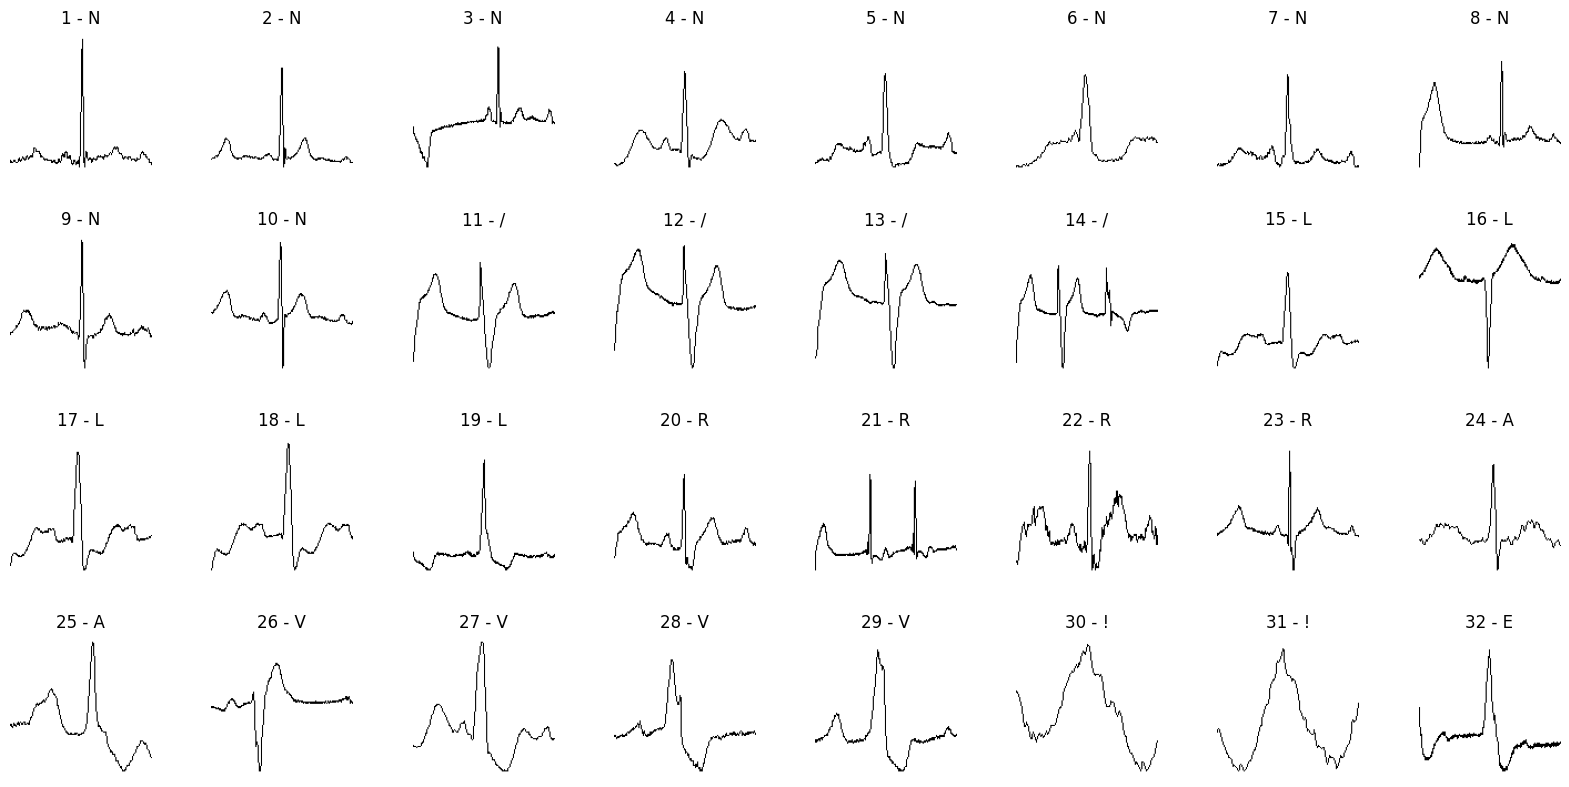

In [42]:
from mpl_toolkits.axes_grid1 import ImageGrid


fig = plt.figure(figsize=(20., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.6,  # pad between axes in inch.
                 )

for j in range(quant_per_batch):
    ax = grid[j]
    show_image(x_np[j], axis= ax)
    ax.set_title(f'{j+1} - {list_beat_type[j]}')

plt.savefig(os.path.join(figures_directory, 'jun_2018/batch_example.png'))

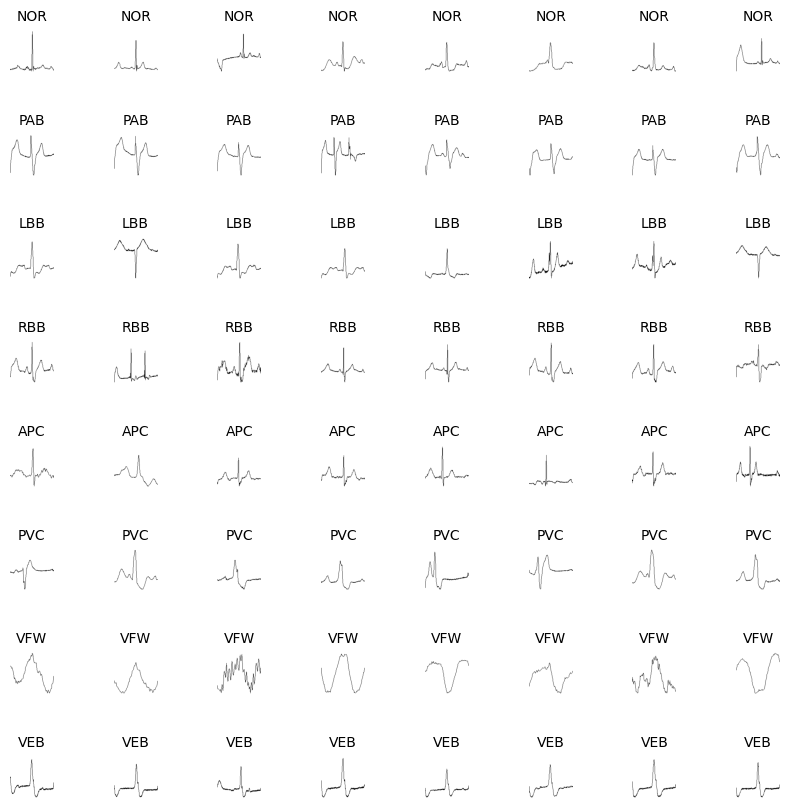

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

dict_quant_per_batch = {
    'N': 8,
    'L': 8,
    'R': 8,
    'V': 8,
    '/': 8,
    'A': 8,
    '!': 8,
    'E': 8,
 }


fig = plt.figure(figsize=(20., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 8),  # creates 2x2 grid of axes
                 axes_pad=0.6,  # pad between axes in inch.
                 )

for j in range(quant_per_batch):
    ax = grid[j]
    show_image(x_np[j], axis= ax)
    ax.set_title(f'{dict_beat_acronyms[list_beat_type[j]]}', fontsize=10)

#plt.savefig(os.path.join(figures_directory, 'jun_2018/beats_example.png'))